In [1]:
%tensorflow_version 1.x
import tensorflow
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime

seed = 42
np.random.seed(seed)
% matplotlib inline

TensorFlow 1.x selected.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
IMAGE_DIRECTORY = '/content/drive/My Drive/Springboard DS Course/CAPSTONE 2/IMAGES/REDUCED_DATASET'
REPOSITORY = '/content/drive/My Drive/Springboard DS Course/REPOSITORY/springboard'
os.chdir(REPOSITORY+'/faces_capstone2')

In [4]:
from keras.models import Sequential

class Decoder(Sequential):
  def load_data(self, cat_dir, face_dir, n_images):
    self.imgs = []
    #cat_samples = np.random.choice(cat_dir, int(n_images/2), replace=False)
    cat_samples = cat_dir
    #face_samples = np.random.choice(face_dir, int(n_images/2), replace=False)
    face_samples = face_dir
    all_samples = np.concatenate((cat_samples, face_samples))
    try:
      for file in tqdm(all_samples):
        fn = IMAGE_DIRECTORY + '/' + file
        img = cv2.imread(fn)
        rgb_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        self.imgs.append(rgb_image.astype(np.float32) / 255.)
    except:
      print(file)
    np.random.shuffle(self.imgs)
    x_all = np.arange(len(self.imgs))
    self.all_dim = np.asarray(self.imgs).shape[0]
    X = np.array(x_all)
    y = np.array(self.imgs)
    self.X = X
    self.y = y
    return X, y
  def build_model(self, n_components, model_filename, n_dim, decoder=None):
    os.chdir(REPOSITORY+'/faces_capstone2')
    decoder = Sequential()
    decoder.add(Embedding(input_dim=n_dim, output_dim=n_components, input_length=1))
    decoder.add(Flatten(name='encoder_output'))
    decoder.add(Reshape((1, 1, n_components), name='decoder_input'))
    decoder.add(Conv2DTranspose(filters=64, kernel_size=3, strides=1, activation='relu'))
    decoder.add(Conv2DTranspose(filters=64, kernel_size=3, strides=1, activation='relu'))
    decoder.add(Conv2DTranspose(filters=32, kernel_size=3, strides=1, activation='relu'))
    decoder.add(Conv2DTranspose(filters=32, kernel_size=3, strides=2, activation='relu'))
    decoder.add(Conv2DTranspose(filters=16, kernel_size=3, strides=2, activation='relu'))
    decoder.add(Conv2DTranspose(filters=16, kernel_size=3, strides=2, activation='relu'))
    decoder.add(Conv2DTranspose(filters=8, kernel_size=3, strides=2, activation='relu'))
    decoder.add(Conv2DTranspose(filters=3, kernel_size=4, strides=2, activation='sigmoid'))
    decoder.compile(optimizer='adam', loss='mse')
    self.model_filename = model_filename
    decoder.save(self.model_filename)
    self.decoder = decoder
  def fit_model(self, X, y, model_filename, batch_size, n_epochs):
    os.chdir(REPOSITORY+'/faces_capstone2')
    model = load_model(model_filename)
    model_hist = model.fit(X, y, batch_size=batch_size, epochs=n_epochs, validation_split=0.2)
    model.save(model_filename)
  def predict_model(self, X, y, model_filename, batch_size):
    os.chdir(REPOSITORY+'/faces_capstone2')
    self.decoder = load_model(model_filename)
    return self.decoder.predict(X, batch_size=batch_size)

Using TensorFlow backend.


In [5]:
decoder_model = Decoder()

img_list = os.listdir(IMAGE_DIRECTORY)
cat_dir = []
face_dir = []
for filename in tqdm(img_list):
  if '_' in filename:
    cat_dir.append(filename)
  else:
    face_dir.append(filename)

100%|██████████| 200/200 [00:00<00:00, 568719.19it/s]


In [0]:
from keras.models import load_model
from keras.layers import Activation, Input, Flatten, Reshape
from keras.layers.convolutional import Conv2DTranspose
from keras.layers.embeddings import Embedding
from keras.callbacks import CSVLogger
from keras import backend as K
K.set_image_data_format('channels_last')
K.clear_session()

In [0]:
BATCH_SIZE = 32 #make it like 32 or 64 or something
N_COMPONENTS = 50
MODEL_FN = 'decoder_50c.h5'
LOGS_FN = 'train_log_50c.csv'
N_EPOCHS = 10000
N_IMAGES = 200
NEW_MODEL = False

if NEW_MODEL:
  decoder_model.build_model(N_COMPONENTS, MODEL_FN, n_dim=N_IMAGES)

In [26]:
X, y = decoder_model.load_data(cat_dir, face_dir, n_images=N_IMAGES)
os.chdir(REPOSITORY+'/faces_capstone2')
model = load_model(MODEL_FN)
model_logger = CSVLogger(LOGS_FN, separator=',', append=True)
model_hist = model.fit(X, y, batch_size=BATCH_SIZE, epochs=N_EPOCHS, validation_split=0.2, callbacks=[model_logger])
model.save(MODEL_FN)

100%|██████████| 200/200 [00:00<00:00, 297.37it/s]


Streaming output truncated to the last 5000 lines.
160/160 [==============================] - 0s 826us/step - loss: 0.0053 - val_loss: 0.0801
Epoch 7502/10000
160/160 [==============================] - 0s 814us/step - loss: 0.0053 - val_loss: 0.0803
Epoch 7503/10000
160/160 [==============================] - 0s 813us/step - loss: 0.0053 - val_loss: 0.0802
Epoch 7504/10000
160/160 [==============================] - 0s 812us/step - loss: 0.0053 - val_loss: 0.0802
Epoch 7505/10000
160/160 [==============================] - 0s 817us/step - loss: 0.0053 - val_loss: 0.0803
Epoch 7506/10000
160/160 [==============================] - 0s 826us/step - loss: 0.0053 - val_loss: 0.0803
Epoch 7507/10000
160/160 [==============================] - 0s 825us/step - loss: 0.0054 - val_loss: 0.0802
Epoch 7508/10000
160/160 [==============================] - 0s 820us/step - loss: 0.0054 - val_loss: 0.0800
Epoch 7509/10000
160/160 [==============================] - 0s 816us/step - loss: 0.0054 - val_loss: 0

In [8]:
from keras.models import load_model

X, y = decoder_model.load_data(cat_dir, face_dir, n_images=200)

os.chdir(REPOSITORY+'/faces_capstone2')
model = load_model(MODEL_FN)
compressed = model.predict(X, batch_size=BATCH_SIZE)

100%|██████████| 200/200 [02:06<00:00,  1.58it/s]


Instructions for updating:
If using Keras pass *_constraint arguments to layers.



95


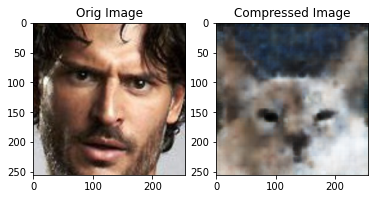

In [25]:
PIC = np.random.choice(N_IMAGES)
print(PIC)
plt.subplot(1,2,1)
plt.imshow(decoder_model.imgs[PIC])
plt.title('Orig Image')

plt.subplot(1,2,2)
plt.imshow(compressed[PIC])
plt.title('Compressed Image')

plt.show()

In [0]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1, 100)            2000      
_________________________________________________________________
encoder_output (Flatten)     (None, 100)               0         
_________________________________________________________________
decoder_input (Reshape)      (None, 1, 1, 100)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 3, 3, 64)          57664     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 5, 5, 64)          36928     
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 7, 7, 32)          18464     
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 15, 15, 32)       

In [0]:
os.chdir(REPOSITORY+'/faces_capstone2')
log = pd.read_csv(LOGS_FN)
log.head()

,Date,Run_Number,Num_Epochs_Tot,Train_Loss,Valid_Loss
0,2020-03-10 02:27:40.443648,0,0,NaN,NaN
1,2020-03-10 02:28:16.455108,1,5,0.031323,0.057537
2,2020-03-10 02:28:58.949584,2,10,0.019592,0.059774
3,2020-03-10 02:29:45.312118,3,15,0.015328,0.060629
4,2020-03-10 02:30:29.528276,4,20,0.013094,0.059538


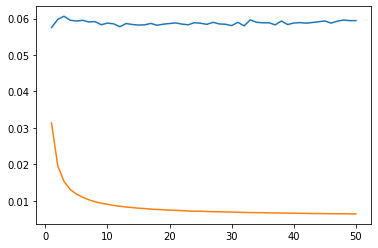

In [0]:
plt.plot(log[['Valid_Loss', 'Train_Loss']])
plt.show()